In [1]:
import os
import sys
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import ipywidgets as widgets
from IPython.display import display

os.environ["FEFLOW_KERNEL_VERSION"] = "75"  # use the FEFLOW 7.4 API
import ifm_contrib as ifm  # ifm_contrib is code compatible with ifm.

print(f"This is FEFLOW {(ifm.getKernelVersion()/1000):.3f} (build {ifm.getKernelRevision()}).")

This is FEFLOW 7.460 (build 19524).


In [2]:
ifm.forceLicense("Viewer")

In [3]:
# confined version
doc = ifm.loadDocument("../../../unittests/models/results/benchmark_pathlines1D_2Dconf.dac")
#doc = ifm.loadDocument("../../../unittests/results/benchmark_pathlines1D_2Dunconf.dac")
#doc = ifm.loadDocument("../../../unittests/results/benchmark_pathlines1D_3Dconf.dac")

In [4]:
#doc.loadTimeStep(0)

## Particle Tracking Feature

ifm_contrib extends the particle tracking feauture:
+ Particle is provided as DataFrame (not as list as in ifm_classic)
+ adds the simulation DateTime (if Reference Date is set in model)

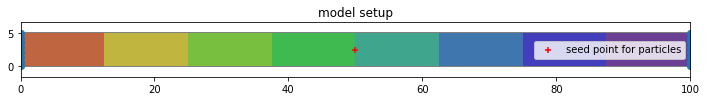

In [5]:
# define the seed point and show the model
seed_point = (50, 2.5, -10.5)

fig, ax1 = plt.subplots(1, figsize=(12,1))

doc.c.plot.faces()
doc.c.plot.fringes(par=ifm.Enum.P_HEAD)
doc.c.mesh.gdf.nodes(par=ifm.Enum.P_BCFLOW_1ST).dropna().plot(ax=ax1)

ax1.scatter([seed_point[0]],[seed_point[1]], marker="+", color="red", label="seed point for particles")
ax1.legend(loc="right")
ax1.set_title("model setup")

plt.axis("equal")

None

In [6]:
# create the PathLine object 

settings = {"tracking_mode" : ifm.Enum.PT_MODE_STEADY,
            "tracking_direction" : ifm.Enum.PT_DIR_FORWARD,
            "tracking_type" : ifm.Enum.PT_TYPE_RW}

pl = doc.c.particles.particle(seed_point, time_start=datetime(2002, 1, 30), 
                              forward=True, unsteady=False, random_walk=True)

In [7]:
# show as table
pl.df.head()

,x,y,tau,z,sim_time,calendar,geometry
0,50.00000,2.500000,0.000000,None,760.000977,2002-01-30 00:01:24.375000,POINT (50.00000 2.50000)
1,49.64539,2.560303,0.926381,None,760.927358,2002-01-30 22:15:23.717913,POINT (49.64539 2.56030)
2,50.35461,2.402286,2.648652,None,762.649629,2002-02-01 15:35:27.916167,POINT (50.35461 2.40229)
3,50.35461,2.334315,7.900785,None,767.901762,2002-02-06 21:38:32.209042,POINT (50.35461 2.33432)
4,50.60808,2.142857,11.338590,None,771.339567,2002-02-10 08:08:58.551822,POINT (50.60808 2.14286)


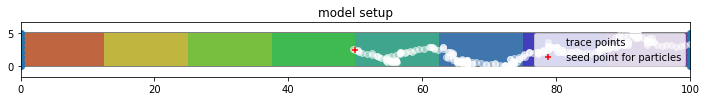

In [8]:
# visualize it 
fig, ax1 = plt.subplots(1, figsize=(12,1))
doc.c.plot.faces()
doc.c.plot.fringes(par=ifm.Enum.P_HEAD)
doc.c.mesh.gdf.nodes(par=ifm.Enum.P_BCFLOW_1ST).dropna().plot(ax=ax1)
# plot seed point and trace
pl.gdf.plot(ax=ax1, label="trace points", alpha=0.5, color="white")
ax1.scatter([seed_point[0]],[seed_point[1]], marker="+", color="red", label="seed point for particles")
# figure format
ax1.legend(loc="right")
ax1.set_title("model setup")
plt.axis("equal")
None

The `get_location_at_time()` method returns the location of the particle at a specific time:

In [9]:
# for a single date a DataSeries is returned
pl.get_location_at_time(datetime(2002, 2, 7))

x           50.3619
y           2.32884
tau         7.99902
z               NaN
sim_time        768
geometry        NaN
Name: 2002-02-07 00:00:00, dtype: object

if a list of dates is provided, a Geodata is returned. Note that NaN is returned if the time is outside the particles lifetime.

In [10]:
# get two locations
gdf_location = pl.get_location_at_time([datetime(2002, 1, 15),
                                        datetime(2002, 4, 15),
                                        datetime(2002, 7, 15),
                                        datetime(2002, 10, 15),
                                        datetime(2002, 11, 15),
                                        datetime(2003, 4, 15),
                                        datetime(2003, 7, 15)], geodataframe=True)
gdf_location

,x,y,tau,z,sim_time,geometry
2002-01-15,NaN,NaN,NaN,NaN,NaN,POINT (nan nan)
2002-04-15,56.013350,0.763937,74.999023,NaN,835.0,POINT (56.013 0.764)
2002-07-15,57.253079,2.019106,165.999023,NaN,926.0,POINT (57.253 2.019)
2002-10-15,62.867583,2.718431,257.999023,NaN,1018.0,POINT (62.868 2.718)
2002-11-15,64.537547,1.830880,288.999023,NaN,1049.0,POINT (64.538 1.831)
2003-04-15,65.569345,0.713235,439.999023,NaN,1200.0,POINT (65.569 0.713)
2003-07-15,72.025289,0.157114,530.999023,NaN,1291.0,POINT (72.025 0.157)


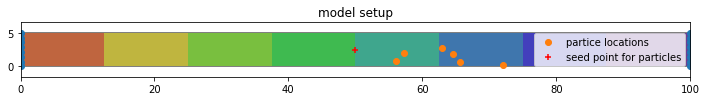

In [11]:
# visualize it 
fig, ax1 = plt.subplots(1, figsize=(12,1))
doc.c.plot.faces()
doc.c.plot.fringes(par=ifm.Enum.P_HEAD)
doc.c.mesh.gdf.nodes(par=ifm.Enum.P_BCFLOW_1ST).dropna().plot(ax=ax1)
# plot seed point and trace
gdf_location.plot(ax=ax1, label="partice locations", alpha=1.0)
ax1.scatter([seed_point[0]],[seed_point[1]], marker="+", color="red", label="seed point for particles")
# figure format
ax1.legend(loc="right")
ax1.set_title("model setup")
plt.axis("equal")
None

### Backwards Tracking




In [12]:
settings = {"tracking_mode" : ifm.Enum.PT_MODE_STEADY,
            "tracking_direction" : ifm.Enum.PT_DIR_BACKWARD,
            "tracking_type" : ifm.Enum.PT_TYPE_RW}

pl = doc.c.particles.particle(seed_point, time_start=datetime(2002, 1, 30), 
                              forward=False, random_walk=True)

In [13]:
# show as table
pl.df.head()

,x,y,tau,z,sim_time,calendar,geometry
0,50.00000,2.500000,0.000000,None,760.000977,2002-01-30 00:01:24.375000,POINT (50.00000 2.50000)
1,49.64539,2.622893,-6.390701,None,753.610276,2002-01-23 14:38:47.807151,POINT (49.64539 2.62289)
2,49.64539,2.356882,-10.438048,None,749.562929,2002-01-19 13:30:37.054410,POINT (49.64539 2.35688)
3,48.93617,2.463298,-13.309206,None,746.691771,2002-01-16 16:36:09.009736,POINT (48.93617 2.46330)
4,48.22695,2.269559,-24.226585,None,735.774391,2002-01-05 18:35:07.389014,POINT (48.22695 2.26956)


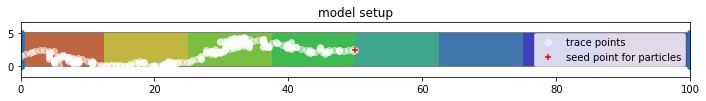

In [14]:
# visualize it 
fig, ax1 = plt.subplots(1, figsize=(12,1))
doc.c.plot.faces()
doc.c.plot.fringes(par=ifm.Enum.P_HEAD)
doc.c.mesh.gdf.nodes(par=ifm.Enum.P_BCFLOW_1ST).dropna().plot(ax=ax1)
# plot seed point and trace
pl.gdf.plot(ax=ax1, label="trace points", alpha=0.5, color="white")
ax1.scatter([seed_point[0]],[seed_point[1]], marker="+", color="red", label="seed point for particles")
# figure format
ax1.legend(loc="right")
ax1.set_title("model setup")
plt.axis("equal")
None

In [15]:
# get two locations
gdf_location = pl.get_location_at_time([datetime(2002, 1, 15),
                                        datetime(2001, 11, 15),
                                        datetime(2001, 9, 15),
                                        datetime(2001, 7, 15),
                                        datetime(2001, 5, 15),
                                        ], geodataframe=True)
gdf_location

,x,y,tau,z,sim_time,geometry
2002-01-15,48.826269,2.433276,-15.000977,NaN,745.0,POINT (48.82627 2.43328)
2001-11-15,44.838685,2.385036,-76.000977,NaN,684.0,POINT (44.83869 2.38504)
2001-09-15,41.504710,2.732683,-137.000977,NaN,623.0,POINT (41.50471 2.73268)
2001-07-15,39.692324,3.145120,-199.000977,NaN,561.0,POINT (39.69232 3.14512)
2001-05-15,36.275799,3.424116,-260.000977,NaN,500.0,POINT (36.27580 3.42412)


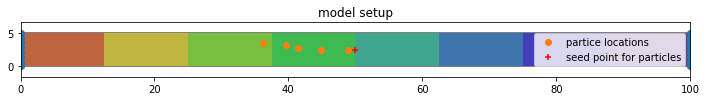

In [16]:
# visualize it 
fig, ax1 = plt.subplots(1, figsize=(12,1))
doc.c.plot.faces()
doc.c.plot.fringes(par=ifm.Enum.P_HEAD)
doc.c.mesh.gdf.nodes(par=ifm.Enum.P_BCFLOW_1ST).dropna().plot(ax=ax1)
# plot seed point and trace
gdf_location.plot(ax=ax1, label="partice locations", alpha=1.0)
ax1.scatter([seed_point[0]],[seed_point[1]], marker="+", color="red", label="seed point for particles")
# figure format
ax1.legend(loc="right")
ax1.set_title("model setup")
plt.axis("equal")
None

## Particle Swarm

The Particle Swarm is an ensemble of particles. It allows for easier handling of many particles that are to be evaulated as an entirety

In [17]:
def plot_particle_location(time):
    
    fig, ax1 = plt.subplots(1, figsize=(12,1))
    
    doc.c.plot.faces()
    doc.c.plot.fringes(par=ifm.Enum.P_HEAD)
    doc.c.mesh.gdf.nodes(par=ifm.Enum.P_BCFLOW_1ST).dropna().plot(ax=ax1)

    # plot seed point and trace
    pls.particle_position_at_time(time).plot(ax=ax1, color="white", label="particles", markersize=3)
    pls.seed_points().plot(ax=ax1, marker="+", color="red", label="seed points")

    # figure format
    ax1.legend(loc="right")
    ax1.set_title(f"{time}")
    plt.axis("equal")
    
    plt.show()

In [18]:
# create sample particle swarm with 20 members
pls = doc.c.particles.particle_swarm(forward=True, random_walk=True)
seed = (50, 2.5, -10.5)  # seed at (x,y,z)
pls.append_particle(seed, time_start=datetime(2000, 1, 1), count=20)

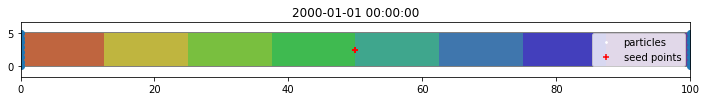

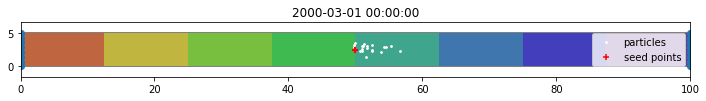

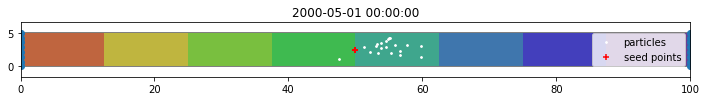

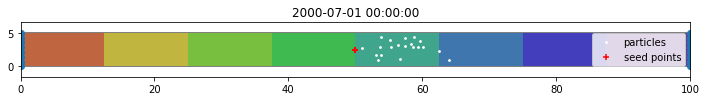

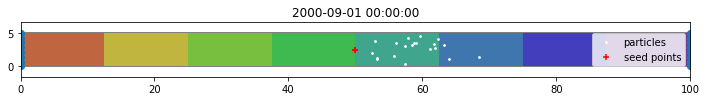

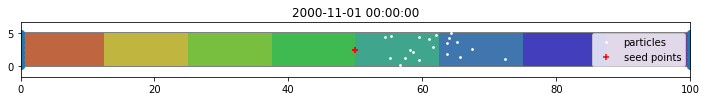

In [19]:
# plot their movement over time
for month in range(1, 13, 2):
    plot_particle_location(datetime(2000, month, 1))

plot the trajectories

(-1.3877787807814457e-15,
 100.00000000000001,
 -2.7755575615628914e-16,
 5.000000000000001)

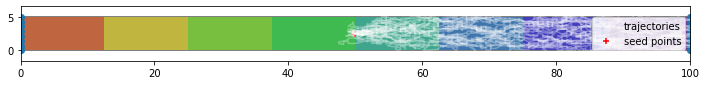

In [20]:
fig, ax1 = plt.subplots(1, figsize=(12,1))
    
doc.c.plot.faces()
doc.c.plot.fringes(par=ifm.Enum.P_HEAD)
doc.c.mesh.gdf.nodes(par=ifm.Enum.P_BCFLOW_1ST).dropna().plot(ax=ax1)

pls.trajectories().plot(ax=ax1, color="white", alpha=0.3, label="trajectories")
pls.seed_points().plot(ax=ax1, marker="+", color="red", label="seed points")


# figure format
ax1.legend(loc="right")
plt.axis("equal")

## Seeding at multiple times


In [21]:
# adding more particles, started at different seed point and -time
pls.append_particle((20, 2.5, -10.5), time_start=datetime(2000, 6, 1),
                    count=20)

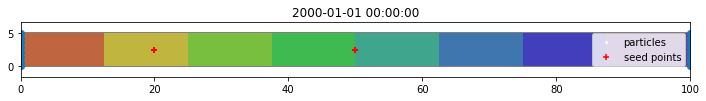

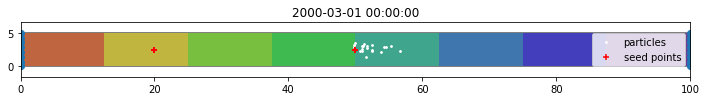

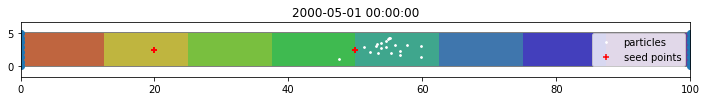

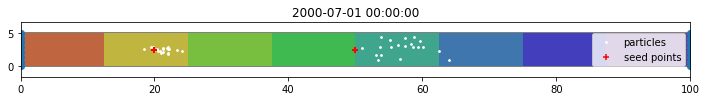

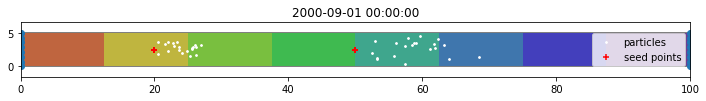

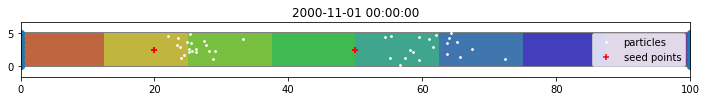

In [22]:
# plot their movement over 
for m in range(1, 13, 2):
    plot_particle_location(datetime(2000, m, 1))

## Movie Time

In [23]:
# https://matplotlib.org/examples/animation/moviewriter.html
import ipywidgets as widgets
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as manimation

In [24]:
# the settings can also be provided as a single dictionary, 
# in this case the other options are overridden
settings = {"tracking_mode" : ifm.Enum.PT_MODE_STEADY,
            "tracking_direction" : ifm.Enum.PT_DIR_FORWARD,
            "tracking_type" : ifm.Enum.PT_TYPE_RW}

pls = doc.c.particles.ParticleSwarm(doc, default_settings=settings)

In [25]:
# seed 20 particle each at three different location and different time
pls.append_particle((50 , 2.5 , -10.5), count=80, time_start=datetime(2000, 1, 1))
pls.append_particle((40 , 2.5 , -10.5), count=80, time_start=datetime(2000, 6, 1))
pls.append_particle((30 , 2.5 , -10.5), count=80, time_start=datetime(2001, 1, 1))

In [26]:
# define the travel period
start_date = datetime(2000, 1, 1)
end_date = datetime(2004, 1, 1)
freq = "D"
fps=24

In [27]:
timestages = pd.date_range(start_date, end_date, freq=freq).to_pydatetime() 
print(f"number of timestages to render {len(timestages)}")
print(f"length of movie : {(len(timestages) / fps):.1f} sec")

p = widgets.IntProgress(max=len(timestages))
display(p)
p.value = 0

number of timestages to render 1462
length of movie : 60.9 sec


IntProgress(value=0, max=1462)

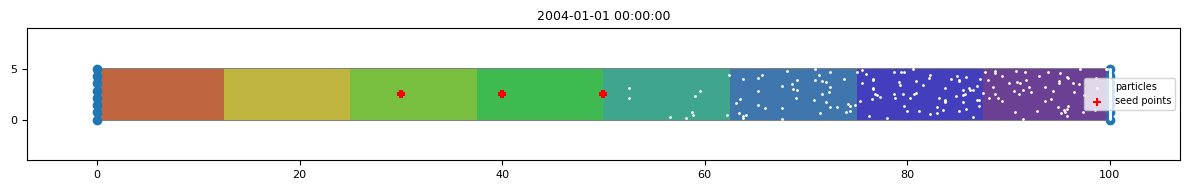

In [28]:
# format figure
plt.style.use("DHI")
fig, ax1 = plt.subplots(1, figsize=(12,2))

# initialize the writer
FFMpegWriter = manimation.writers['ffmpeg']
writer = FFMpegWriter(fps=fps)

# render one image per time step   
with writer.saving(fig, "./particle_animation.mp4", fig.dpi):
    for time in timestages:
        
        # update progress bar
        p.value += 1
        p.description = str(time)

        # clear figure
        ax1.clear()

        # plot the figure    
        doc.c.plot.faces()
        doc.c.plot.fringes(par=ifm.Enum.P_HEAD)
        doc.c.mesh.gdf.nodes(par=ifm.Enum.P_BCFLOW_1ST).dropna().plot(ax=ax1)

        pls.particle_position_at_time(time).plot(ax=ax1, color="white", label="particles", markersize=1)
        pls.seed_points().plot(ax=ax1, marker="+", color="red", label="seed points")

        # figure format
        ax1.legend(loc="right")
        ax1.set_title(f"{time}")
        plt.axis("equal")

        # add frame to animation
        writer.grab_frame()